In [2]:
import csv
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as mpl
import numpy as np
from pathlib import Path
import json
import os

In [4]:
#get average reward from a single json evaluation file
def get_average_reward(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return np.mean(data)

def get_reward(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

problem_instance = "spirits_1102_n"
actor_pipeline_config = "full_blending_py0_nn_xy12_lp_50w"

results_dir = Path(f"{os.getcwd()}/problem_configurations/{problem_instance}/training_results/{actor_pipeline_config}/evaluation_results_{actor_pipeline_config}.json")
print(f"average reward {actor_pipeline_config} {problem_instance}: {get_average_reward(results_dir)}")
lp_dir = Path(f"{os.getcwd()}/problem_configurations/{problem_instance}/evaluation_LP.json")
if lp_dir.exists():
    average_reward_lp = get_average_reward(lp_dir)
    print(f"average reward LP {problem_instance}: {average_reward_lp}")
else:
    average_reward_lp = None
    print(f"LP evaluation file not found for {problem_instance}")



average reward full_blending_py0_nn_xy12_lp_50w spirits_1102_n: 0.9463385915893989
average reward LP spirits_1102_n: 0.9292730550998382


In [5]:
problem_instances = ["spirits_112_n", "spirits_112", "spirits_102_n", "spirits_102", "spirits_012_n", "spirits_012", "spirits_002_n", "spirits_002",  "spirits_1102_n", "spirits_1102", "spirits_1002_n", "spirits_1002", "spirits_0102_n", "spirits_0102", "spirits_0002_n", "spirits_0002"]

#get average rewards over all problem instances relative to the upper bound
def get_average_rewards(problem_instances, actor_pipeline_config):
    average_rewards = []
    for instance in problem_instances:
        if actor_pipeline_config in ["LP", "NVP+VOL", "NVP+NVt", "2DO+VOL", "2DO+NVt"]:
            results_dir = Path(f"{os.getcwd()}/problem_configurations/{instance}/evaluation_{actor_pipeline_config}.json")
        else:
            results_dir = Path(f"{os.getcwd()}/problem_configurations/{instance}/training_results/{actor_pipeline_config}/evaluation_results_{actor_pipeline_config}.json")
        if results_dir.exists():
            average_reward = get_average_reward(results_dir)
            average_rewards.append((average_reward+1)/2)
        else:
            print(f"Results file not found for {instance}")
            average_rewards.append(None)
    return np.mean(average_rewards)

#get rewards for each problem instance and actor pipeline config
def get_rewards_per_instance(problem_instances, actor_pipeline_config):
    rewards = {}
    for instance in problem_instances:
        if actor_pipeline_config in ["LP", "NVP+VOL", "NVP+NVt", "2DO+VOL", "2DO+NVt"]:
            results_dir = Path(f"{os.getcwd()}/problem_configurations/{instance}/evaluation_{actor_pipeline_config}.json")
        else:
            results_dir = Path(f"{os.getcwd()}/problem_configurations/{instance}/training_results/{actor_pipeline_config}/evaluation_results_{actor_pipeline_config}.json")
        if results_dir.exists():
            reward_data = np.array(get_reward(results_dir))
            rewards[instance] = (reward_data+1)/2
        else:
            print(f"Results file not found for {instance}")
            rewards[instance] = None
    return rewards

# Get average rewards for each heuristic
heuristics = ["LP", "NVP+VOL", "NVP+NVt", "2DO+VOL", "2DO+NVt"]
average_rewards_heuristics = {heuristic: get_rewards_per_instance(problem_instances, heuristic) for heuristic in heuristics}
print(average_rewards_heuristics)
#and per instance
#Get average rewards for each actor pipeline config
actor_pipeline_configs = ["full_blending_p_nn_xy_lp_50w", "full_blending_py0_nn_xy12_lp_50w", "full_blending_py01_nn_xy2_lp_50w",  "full_blending_py_nn_x_lp_50w", "full_blending_full_nn_none_lp_50w", "full_blending_p_nn_xy_lp_50w_ppo"]
average_rewards_configs = {config: get_rewards_per_instance(problem_instances, config) for config in actor_pipeline_configs}
print(average_rewards_configs)


#Get percentage reduction of gap to the upper bound as compared to LP for each problem instance and actor pipeline config
def get_percentage_reduction(problem_instances, actor_pipeline_configs, average_rewards_instances, average_reward_lp):
    percentage_reductions = {}
    for instance in problem_instances:
        percentage_reductions[instance] = {}
        for config in actor_pipeline_configs:
            if average_reward_lp[instance] is not None and average_rewards_instances[instance][config] is not None:
                reduction = (average_reward_lp[instance] - average_rewards_instances[instance][config]) / (1- average_reward_lp[instance]) * 100
                percentage_reductions[instance][config] = reduction
            else:
                percentage_reductions[instance][config] = None
    return percentage_reductions

# percentage_reductions = get_percentage_reduction(problem_instances, actor_pipeline_configs, average_rewards_instances, average_rewards_heuristics_instances["LP"])
# print(percentage_reductions)

#similar to the above but for each reward individually
from scipy import stats
def get_percentage_reductions_per_instance(problem_instances, actor_pipeline_configs, average_rewards_instances, average_reward_lp):
    percentage_reductions = {}
    significance = {}
    for instance in problem_instances:
        percentage_reductions[instance] = {}
        significance[instance] = {}
        for config in actor_pipeline_configs:
            if average_reward_lp[instance] is not None and average_rewards_instances[config][instance] is not None:
                reductions = []
                for k,v in enumerate(average_reward_lp[instance]):
                    reduction = (average_reward_lp[instance][k] - average_rewards_instances[config][instance][k]) / (1 - average_reward_lp[instance][k]) * 100
                    reductions.append(reduction)
                percentage_reductions[instance][config] = np.mean(reductions)
                t_stat, p_value = stats.ttest_1samp(reductions, 0)
                significance[instance][config] = "***" if p_value < 0.01 else ("**" if p_value < 0.05 else ("*" if p_value < 0.1 else "ns")) # t-test to check if the mean reduction is significantly different from zero
                
            else:
                percentage_reductions[instance][config] = None
    return percentage_reductions, significance

percentage_reductions, significance = get_percentage_reductions_per_instance(problem_instances, actor_pipeline_configs, average_rewards_configs, average_rewards_heuristics["LP"])

#check if percentage reductions are significantly different from zero using a t-test


#pretty print the percentage reductions in a table format including significance
def print_percentage_reductions_table(percentage_reductions):
    print(f"{'Instance':<20}", end="")
    for config in percentage_reductions[next(iter(percentage_reductions))].keys():
        print(f"{config:<20}", end="")
    print()
    
    for instance, reductions in percentage_reductions.items():
        print(f"{instance:<20}", end="")
        for config, reduction in reductions.items():
            if reduction is not None:
                significance_symbol = significance[instance][config]
                print(f"{reduction:.1f}% {significance_symbol:<3}", end="")
            else:
                print("N/A               ", end="")
        print() 
print_percentage_reductions_table(percentage_reductions)

#get average percentage reduction for each actor pipeline config across problem instances
def get_average_percentage_reductions(actor_pipeline_configs, percentage_reductions):
    average_reductions = {}
    significance = {}
    for config in actor_pipeline_configs:
        reductions = [percentage_reductions[instance][config] for instance in percentage_reductions if percentage_reductions[instance][config] is not None]
        average_reductions[config] = np.mean(reductions) if reductions else None
        p_value = stats.ttest_1samp(reductions, 0)[1]
        significance[config] = "***" if p_value < 0.01 else ("**" if p_value < 0.05 else ("*" if p_value < 0.1 else "ns"))
    return average_reductions, significance
average_percentage_reductions, significance_average = get_average_percentage_reductions(actor_pipeline_configs, percentage_reductions)
print("Average percentage reductions:")
for config, reduction in average_percentage_reductions.items():
    print(f"{config}: {reduction:.2f}%")   
    significance_symbol = significance_average[config]
    print(f"Significance: {significance_symbol}") 


for heuristic in heuristics:
    average_reward = get_average_rewards(problem_instances, heuristic)
    print(f"Average reward for {heuristic}: {average_reward:.3f}")

#pretty print the heuristic rewards per instance in a table format
def print_heuristic_rewards_table(average_rewards_heuristics):
    print(f"{'Instance':<20}", end="")
    for heuristic in average_rewards_heuristics.keys():
        print(f"{heuristic:<20}", end="")
    print()
    
    for instance in problem_instances:
        print(f"{instance:<20}", end="")
        for heuristic, rewards in average_rewards_heuristics.items():
            if rewards[instance] is not None:
                print(f"{np.mean(rewards[instance]):<20.3f}", end="")
            else:
                print("N/A                 ", end="")
        print()

print_heuristic_rewards_table(average_rewards_heuristics)


{'LP': {'spirits_112_n': array([0.95714766, 0.95797535, 0.96906416, 0.96213442, 0.96249584,
       0.966482  , 0.9575541 , 0.963527  , 0.96849772, 0.97568111,
       0.97017591, 0.97231856, 0.97033288, 0.96929002, 0.9682234 ,
       0.97494106, 0.97034699, 0.98294382, 0.96662368, 0.96524123,
       0.97040623, 0.97672256, 0.96652383, 0.96764801, 0.96438714,
       0.96430824, 0.98131859, 0.97813254, 0.97992384, 0.9796953 ]), 'spirits_112': array([0.96831565, 0.9731033 , 0.98574504, 0.97835049, 0.97840249,
       0.98091399, 0.97167038, 0.97865057, 0.98347833, 0.99194344,
       0.98456024, 0.98468717, 0.98550737, 0.98562933, 0.98392264,
       0.98915454, 0.98626462, 0.9971115 , 0.98067491, 0.9808799 ,
       0.9846622 , 0.99115665, 0.98278062, 0.98147798, 0.98037528,
       0.97737635, 0.99746091, 0.99304622, 0.99631701, 0.99465049]), 'spirits_102_n': array([0.94775537, 0.94805792, 0.96034992, 0.95309051, 0.95243539,
       0.95747266, 0.9466552 , 0.95435445, 0.96005132, 0.96820027,
 

In [6]:
#determine the best actor pipeline config for each problem instance based on the average reward
def get_best_actor_pipeline_config(problem_instances, average_rewards_configs):
    best_configs = {}
    for instance in problem_instances:
        best_config = None
        best_reward = -np.inf
        for config, rewards in average_rewards_configs.items():
            if rewards[instance] is not None and np.mean(rewards[instance]) > best_reward:
                best_reward = np.mean(rewards[instance])
                best_config = config
        best_configs[instance] = best_config
    return best_configs

best_actor_pipeline_configs = get_best_actor_pipeline_config(problem_instances, average_rewards_configs)
print("Best actor pipeline configs:")
for instance, config in best_actor_pipeline_configs.items():
    print(f"{instance}: {config}")

#get the average percentage reduction of the gap to the upper bound for the best actor pipeline config as compared to LP
def get_average_percentage_reduction_best_config(problem_instances, average_rewards_configs, average_reward_lp):
    average_reductions = {}
    for instance in problem_instances:
        best_config = best_actor_pipeline_configs[instance]
        if average_reward_lp[instance] is not None and average_rewards_configs[best_config][instance] is not None:
            reductions = []
            for k, v in enumerate(average_reward_lp[instance]):
                reduction = (average_reward_lp[instance][k] - average_rewards_configs[best_config][instance][k]) / (1 - average_reward_lp[instance][k]) * 100
                reductions.append(reduction)
            average_reductions[instance] = np.mean(reductions)
        else:
            average_reductions[instance] = None
    return average_reductions

percentage_reduction_best_config = get_average_percentage_reduction_best_config(problem_instances, average_rewards_configs, average_rewards_heuristics["LP"])
#print the average over all problem instances
average_percentage_reductions_best_config = np.mean([v for v in percentage_reduction_best_config.values() if v is not None])
print(f"Average percentage reduction of the gap to the upper bound for the best actor pipeline config as compared to LP: {average_percentage_reductions_best_config:.2f}%")

percentage_reduction_best_config_industry = get_average_percentage_reduction_best_config(problem_instances, average_rewards_configs, average_rewards_heuristics["NVP+VOL"])
print(f"Average percentage reduction of the gap to the upper bound for the best actor pipeline config as compared to NVP+VOL: {np.mean([v for v in percentage_reduction_best_config_industry.values() if v is not None]):.2f}%")

#get average percentage improvement of the best actor pipeline config over LP
def get_average_percentage_improvement_best_config(problem_instances, average_rewards_configs, average_reward_lp):
    average_improvements = {}
    for instance in problem_instances:
        best_config = best_actor_pipeline_configs[instance]
        if average_reward_lp[instance] is not None and average_rewards_configs[best_config][instance] is not None:
            improvements = []
            for k, v in enumerate(average_reward_lp[instance]):
                improvement = (average_rewards_configs[best_config][instance][k] - average_reward_lp[instance][k]) / (average_reward_lp[instance][k]) * 100
                improvements.append(improvement)
            average_improvements[instance] = np.mean(improvements)
        else:
            average_improvements[instance] = None
    return average_improvements

average_percentage_improvement_best_config = get_average_percentage_improvement_best_config(problem_instances, average_rewards_configs, average_rewards_heuristics["LP"])
#print the average over all problem instances
average_percentage_improvement_best_config_value = np.mean([v for v in average_percentage_improvement_best_config.values() if v is not None])
print(f"Average percentage improvement of the best actor pipeline config over LP: {average_percentage_improvement_best_config_value:.2f}%")

#same for NVP+VOL
average_percentage_improvement_best_config_industry = get_average_percentage_improvement_best_config(problem_instances, average_rewards_configs, average_rewards_heuristics["NVP+VOL"])
average_percentage_improvement_best_config_industry_value = np.mean([v for v in average_percentage_improvement_best_config_industry.values() if v is not None])
print(f"Average percentage improvement of the best actor pipeline config over NVP+VOL: {average_percentage_improvement_best_config_industry_value:.2f}%")

#save the best action pipeline config for each problem instance to a json file
def save_best_actor_pipeline_configs(problem_instances, best_configs, file_path):
    best_configs_dict = {instance: config for instance, config in zip(problem_instances, best_configs)}
    with open(file_path, 'w') as file:
        json.dump(best_configs_dict, file, indent=4)

# Define the path to save the best actor pipeline configs
output_file_path = Path(f"{os.getcwd()}/problem_configurations/best_actor_pipeline_configs.json")
# Save the best actor pipeline configs to the specified file
save_best_actor_pipeline_configs(problem_instances, best_actor_pipeline_configs.values(), output_file_path)

Best actor pipeline configs:
spirits_112_n: full_blending_py0_nn_xy12_lp_50w
spirits_112: full_blending_p_nn_xy_lp_50w
spirits_102_n: full_blending_p_nn_xy_lp_50w
spirits_102: full_blending_p_nn_xy_lp_50w
spirits_012_n: full_blending_py01_nn_xy2_lp_50w
spirits_012: full_blending_py01_nn_xy2_lp_50w
spirits_002_n: full_blending_p_nn_xy_lp_50w
spirits_002: full_blending_py0_nn_xy12_lp_50w
spirits_1102_n: full_blending_py0_nn_xy12_lp_50w
spirits_1102: full_blending_py0_nn_xy12_lp_50w
spirits_1002_n: full_blending_p_nn_xy_lp_50w
spirits_1002: full_blending_p_nn_xy_lp_50w
spirits_0102_n: full_blending_py0_nn_xy12_lp_50w
spirits_0102: full_blending_p_nn_xy_lp_50w
spirits_0002_n: full_blending_p_nn_xy_lp_50w
spirits_0002: full_blending_py0_nn_xy12_lp_50w
Average percentage reduction of the gap to the upper bound for the best actor pipeline config as compared to LP: -16.92%
Average percentage reduction of the gap to the upper bound for the best actor pipeline config as compared to NVP+VOL: -85.

In [7]:
#time per iteration analysis
pid = "spirits_002_n"
actor_pipeline_time_configs = ["full_blending_p_nn_xy_lp_50w", "full_blending_py0_nn_xy12_lp_50w", "full_blending_py01_nn_xy2_lp_50w",  "full_blending_py_nn_x_lp_50w", "full_blending_full_nn_none_lp_50w"]
time_items = ["nn_time", "lp_time", "env_time", "train_time"]
#load times files
times = {}
total_times = {}
percentage_times = {}
for config in actor_pipeline_time_configs:
    percentage_times[config] = {}
    file_path = Path(f"{os.getcwd()}/problem_configurations/{pid}/training_results/{config}_times/times_2.json")
    if file_path.exists():
        with open(file_path, 'r') as file:
            times[config] = json.load(file)
        total_times[config] = np.mean(times[config]["sample_time"]) + np.mean(times[config]["train_time"])
        percentage_times[config]["train_time"] = np.mean(times[config]["train_time"]) / total_times[config] * 100
        for item in time_items[:-1]:
            percentage_item = np.mean(times[config][item]) / sum(np.mean(times[config][item]) for item in time_items[:-1]) 
            percentage_times[config][item] = percentage_item * np.mean(times[config]["sample_time"]) / total_times[config] * 100
        #remove lp times from setting full_blending_full_nn_none_lp_50w, readjust the total time, and recalculate the percentage times for env, nn, and train
        if config == "full_blending_full_nn_none_lp_50w":
            #total_times[config] -= total_times[config] * (percentage_times[config]["lp_time"] / 100)
            percentage_times[config]["env_time"] = percentage_times[config]["env_time"] / (1 - percentage_times[config]["lp_time"] / 100)
            percentage_times[config]["nn_time"] = percentage_times[config]["nn_time"] / (1 - percentage_times[config]["lp_time"] / 100)
            percentage_times[config]["train_time"] = percentage_times[config]["train_time"] / (1 - percentage_times[config]["lp_time"] / 100)
            percentage_times[config]["lp_time"] = 0.0
            
    else:
        print(f"Time file not found for {config}")


#pretty print the times in a table format with the total time in seconds and the time items as percentages
def print_time_table(percentage_times):
    print(f"{'Config':<30}", end="")
    print(f"{'Total Time (s)':<20}", end="")
    for item in time_items:
        print(f"{item:<15}", end="")
    print()
    
    for config, times in percentage_times.items():
        total_time = total_times[config] if config in total_times else "N/A"
        print(f"{config:<30}", end="")
        print(f"{total_time:<20.1f}", end="")
        for item in time_items:
            if item in times:
                print(f"{times[item]:<15.1f}", end="")
            else:
                print("N/A            ", end="")
        print()

        
print_time_table(percentage_times)


Config                        Total Time (s)      nn_time        lp_time        env_time       train_time     
full_blending_p_nn_xy_lp_50w  897.9               18.4           54.4           7.0            20.3           
full_blending_py0_nn_xy12_lp_50w878.2               18.7           54.0           7.0            20.4           
full_blending_py01_nn_xy2_lp_50w868.7               18.2           54.5           7.0            20.3           
full_blending_py_nn_x_lp_50w  1052.6              18.9           53.3           7.1            20.7           
full_blending_full_nn_none_lp_50w559.7               40.4           0.0            14.4           45.2           


Industry improvement by factor:
evaporation: - 24.56%, + 30.88%
capacity: - 20.51%, + 34.93%
price: - 24.70%, + 30.74%
target_ages: - 28.24%, + 27.20%
Main effect for evaporation: 6.3%
Main effect for capacity: 14.4%
Main effect for price: 6.0%
Main effect for target_ages: -1.0%


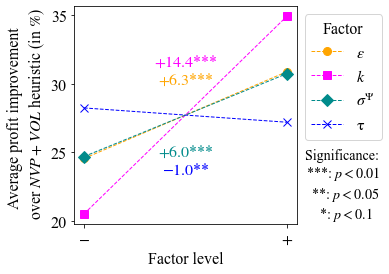

In [50]:
import matplotlib.pyplot as plt

#get improvement of the best actor pipeline config over the industry heuristic sorted by factors
factors = {"evaporation":  {"-": ["spirits_112_n", "spirits_112", "spirits_012_n", "spirits_012", "spirits_1102_n", "spirits_1102", "spirits_0102_n", "spirits_0102"], "+": ["spirits_102_n", "spirits_102", "spirits_002_n", "spirits_002", "spirits_1002_n", "spirits_1002", "spirits_0002_n", "spirits_0002"]}, "capacity": {"-": ["spirits_112_n", "spirits_112", "spirits_102_n", "spirits_102", "spirits_1102_n", "spirits_1102", "spirits_1002_n", "spirits_1002"], "+": ["spirits_012_n", "spirits_012", "spirits_002_n", "spirits_002", "spirits_0102_n", "spirits_0102", "spirits_0002_n", "spirits_0002"]}, "price": {"-": ["spirits_112_n", "spirits_112", "spirits_102_n", "spirits_102", "spirits_012_n", "spirits_012", "spirits_002_n", "spirits_002"], "+": ["spirits_1102_n", "spirits_1102", "spirits_1002_n", "spirits_1002", "spirits_0102_n", "spirits_0102", "spirits_0002_n", "spirits_0002"]}, "target_ages": {"-": ["spirits_112_n", "spirits_102_n", "spirits_012_n", "spirits_002_n", "spirits_1102_n", "spirits_1002_n", "spirits_0102_n", "spirits_0002_n"], "+": ["spirits_112", "spirits_102", "spirits_012", "spirits_002", "spirits_1102", "spirits_1002", "spirits_0102", "spirits_0002"]}}
factor_labels = {"evaporation": "$\epsilon$", "capacity": "$k$", "price": "$\sigma^{\Psi}$", "target_ages": "$\mathrm{\\tau}$"}
factor_colors = {"evaporation": "orange", "capacity": "magenta", "price": "darkcyan", "target_ages": "blue"}
factor_markers = {"evaporation": "o", "capacity": "s", "price": "D", "target_ages": "x"}


industry_improvement_by_factor = {factor: {"-": [], "+": []} for factor in factors.keys()}
for factor in factors.keys():
    for instance in problem_instances:
        sign = "-" if instance in factors[factor]["-"] else "+"
        industry_improvement_by_factor[factor][sign].append(average_percentage_improvement_best_config_industry[instance])

print("Industry improvement by factor:")
for factor, values in industry_improvement_by_factor.items():
    print(f"{factor}: - {np.mean(values['-']):.2f}%, + {np.mean(values['+']):.2f}%")

for factor in factors:
    for sign in ["-", "+"]:
        missing = [instance for instance in factors[factor][sign] if instance not in average_percentage_improvement_best_config_industry]
        if missing:
            print(f"Missing data for factor '{factor}' sign '{sign}': {missing}")

#create a plot showing the main effects of factors on the average improvement of the industry heurisitc NVP+VOL
#there should be one line from minus to plus for each factor, with the x-axis having two ticks (- and +), and the y-axis showing the average improvement in percentage
# Step 2: Prepare data for plotting
factor_order = list(factors.keys())
x_pos = [0.2, 0.7]  # - and + positions on x-axis
x_labels = ["$-$", "$+$"]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(4, 4))



position_factor = {"evaporation": +2, "capacity": +3.3, "price": -3.3, "target_ages": -4.6}
for factor in factor_order:
    #check significantce of the main effect by doing a t-test on pairwise differences
    values = np.array(industry_improvement_by_factor[factor]["+"]) - np.array(industry_improvement_by_factor[factor]["-"])
    if len(values) > 1:
        t_stat, p_value = stats.ttest_rel(industry_improvement_by_factor[factor]["-"], industry_improvement_by_factor[factor]["+"])
        significance = "***" if p_value < 0.01 else ("**" if p_value < 0.05 else ("*" if p_value < 0.1 else "ns"))
    y_values = [
        np.mean(industry_improvement_by_factor[factor]["-"]),
        np.mean(industry_improvement_by_factor[factor]["+"])
    ]
    plt.plot(x_pos, y_values, label=factor_labels[factor], color=factor_colors[factor], marker=factor_markers[factor], linewidth=1, linestyle="--", markersize=8)
    #add text label for the main effect
    main_effect = round(y_values[1] - y_values[0], ndigits=1) 
    print(f"Main effect for {factor}: {main_effect:.1f}%")
    plus_or_minus = "$+$" if main_effect > 0 else "$-$"
    plt.text(np.mean(x_pos), np.mean(y_values)+position_factor[factor], plus_or_minus+f"${str(abs(main_effect))}$"+significance, ha='center', va='bottom', fontsize=16, color=factor_colors[factor])
    

# Step 3: Beautify plot
plt.xticks(x_pos, x_labels)
plt.ylabel("Average profit improvement \n over $NVP+VOL$ heuristic (in $\%$)")
plt.xlabel("Factor level")
#plt.grid(True, linestyle="--", alpha=0.6)
#place the legend outside the plot
plt.legend(title="Factor", loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
#provide a text legend for the p values below other legend
plt.text(1.21, 0.35, "Significance: \n***: $p < 0.01$ \n **: $p < 0.05$ \n *: $p < 0.1$", ha='center', va='top', fontsize=14, transform=plt.gca().transAxes)
#plt.tight_layout()
plt.savefig("factor_effects_industry_improvement.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [18]:
import csv
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as mpl
import numpy as np
from pathlib import Path
import json


default_path = "C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations"

#array of problem configuration folders
problems = {"average": ["spirits_002", "spirits_012", "spirits_102", "spirits_112", "spirits_0002", "spirits_1002", "spirits_1102", "spirits_0102"], "minimum": ["spirits_001", "spirits_011", "spirits_101", "spirits_111", "spirits_0001", "spirits_1001", "spirits_1101", "spirits_0101"]}
matching_problems = [["spirits_002", "spirits_001"], ["spirits_012", "spirits_011"], ["spirits_102", "spirits_101"], ["spirits_112", "spirits_111"], ["spirits_0002", "spirits_0001"], ["spirits_1002", "spirits_1001"], ["spirits_1102", "spirits_1101"], ["spirits_0102", "spirits_0101"]]
minimum_equivalents = {p[0]: p[1] for p in matching_problems}
done_problems = {"average": [p for p in problems["average"] if Path(default_path+"/"+p+"/DONE.txt").is_file()], "minimum": [p for p in problems["minimum"] if Path(default_path+"/"+p+"/DONE.txt").is_file()]}
configs = ["full_blending_p_nn_xy_lp", "full_blending_py0_nn_xy12_lp", "full_blending_py01_nn_xy2_lp", "full_blending_py_nn_x_lp"]
config_labels = ["$P$", "$P,Y_1$", "$P,Y_1,Y_2}$", "$P,Y_1,Y_2,Y_3}$"]
#colors = ["black","dimgrey" , "darkgrey", "lightgrey"]
colors = ["darkblue","darkturquoise" , "lime", "salmon"]
kpis = ["episode_reward_mean"]

#open csv-files and store data in dictionary
data = {}

print(done_problems)

for prob in done_problems["average"]+done_problems["minimum"]:
    data[prob] = {}
    for k in kpis:
        data[prob][k] = {}
        with open(default_path+"/"+ prob + f"/{k}.csv") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                for header, value in row.items():
                    data[prob][k].setdefault(header, []).append(float(value))

    print(prob)
    #load heuristic average and upper bound from json file
    with open(default_path+"/"+ prob + "/config.json", 'r') as f:
        config_data = json.load(f)
    data[prob]["upper_bound"] = config_data["upper_bound"]["max_reward"]
    if prob in done_problems["average"]:
        data[prob]["heuristic_average"] = config_data["heuristic_average"]
        data[prob]["denorm_heuristic"] = ((data[prob]["heuristic_average"]+1)/2) * data[prob]["upper_bound"]

    data[prob]["best_iteration"] = {k :{c: np.max(data[prob][k][c]) for c in configs} for k in kpis}
    if prob in done_problems["average"]:
        for k in kpis:
            data[prob]["best_iteration"][k]["0_blending_p_nn_xy_lp"] = np.max(data[prob][k]["0_blending_p_nn_xy_lp"])
    # data[prob]["percentage_ub"] = [float(x)/data[prob]["upper_bound"] for x in data[prob]["episode_reward_mean"]]

    data[prob]["denorm_best_iteration"] = {k: {c: ((data[prob]["best_iteration"][k][c]+1)/2) * data[prob]["upper_bound"] for c in configs} for k in kpis}
    if prob in done_problems["average"]:
        for k in kpis:
            data[prob]["denorm_best_iteration"][k]["0_blending_p_nn_xy_lp"] = ((data[prob]["best_iteration"][k]["0_blending_p_nn_xy_lp"]+1)/2) * data[prob]["upper_bound"]
    
    if prob in done_problems["average"] and Path(default_path+"/"+prob+"/training_results/full_blending_p_nn_xy_lp/regression_data.json").is_file(): 
        with open(default_path+"/"+prob+"/training_results/full_blending_p_nn_xy_lp/regression_data.json", 'r') as f:
            regression_data = json.load(f)
        #data[prob]["regression_data"] = regression_data
        data[prob]["avg_reward_regression"] = np.mean(regression_data["rewards"])
        data[prob]["denorm_avg_reward_regression"] = ((data[prob]["avg_reward_regression"]+1)/2) * data[prob]["upper_bound"]
print(data)        

#print average gain over 0 blending for all configurations
gain_0_blending = [data[p]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p]["denorm_best_iteration"]["episode_reward_mean"]["0_blending_p_nn_xy_lp"] - 1 for p in done_problems["average"]]
print("Average gain over 0 blending", np.mean(gain_0_blending))

#get difference between regression reward and heuristic reward for all problems which have regression data
regression_diff = {prob: data[prob]["denorm_avg_reward_regression"] - data[prob]["denorm_heuristic"] for prob in done_problems["average"] if "avg_reward_regression" in data[prob]}
print("REGRESSION DIFFERENCE: ", regression_diff)

print("AVERAGE REWARD REGRESSION: ", {prob: data[prob]["avg_reward_regression"] for prob in done_problems["average"] if "avg_reward_regression" in data[prob]})
print("HEURISTIC AVERAGE: ", {prob: data[prob]["heuristic_average"] for prob in done_problems["average"]})

#get the maximum percentage increase of the episode_reward_mean in the last 30 data samples over all experiments
max_percentage_increase = {prob: [((np.max(data[prob]["episode_reward_mean"][c][-30:])+1)/2) / ((np.max(data[prob]["episode_reward_mean"][c][:-30])+1)/2) - 1 for c in configs] for prob in done_problems["average"]}
max_total = np.max([np.max(max_percentage_increase[prob]) for prob in done_problems["average"]])
#print(max_percentage_increase)
print("MAX REWARD INCREASE IN LAST 30 ITERATIONS: ", max_total)


{'average': ['spirits_002', 'spirits_012', 'spirits_102', 'spirits_112', 'spirits_0002', 'spirits_1002', 'spirits_1102', 'spirits_0102'], 'minimum': ['spirits_001', 'spirits_011', 'spirits_101', 'spirits_111', 'spirits_0001', 'spirits_1001', 'spirits_1101', 'spirits_0101']}
spirits_002
spirits_012
spirits_102
spirits_112
spirits_0002
spirits_1002
spirits_1102
spirits_0102
spirits_001
spirits_011
spirits_101
spirits_111
spirits_0001
spirits_1001
spirits_1101
spirits_0101
{'spirits_002': {'episode_reward_mean': {'Step': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0,

In [17]:
#ACTOR PIPELINE PLOT


#create plot with config on x-axis (label without "full_blending") and relative gain of denorm_best_iteration over denorm_heuristic as mean with std whiskers
#change plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})
xdata = np.arange(len(configs))
#xlabels = [c.replace("full_blending_", "") for c in configs]
#xlabels = [x.split("_")[0] for x in xlabels]
#xlabels = [x.replace("p", "P") for x in xlabels]
xlabels = [config_labels[configs.index(c)] for c in configs]
#gains_over_heuristic = {prob: [(data[prob]["denorm_best_iteration"]["episode_reward_mean"][c]/data[prob]["denorm_heuristic"] - 1)*100 for c in configs] for prob in done_problems["average"]}
gains_ub = {"full_blending_p_nn_xy_lp": np.array([-25.4,-19.6,-11.5,-14.4,-15.5,-21.5,-8.5,-11.5]),
            "full_blending_py0_nn_xy12_lp": np.array([-21.1,-16.9,-6.6,-11.5,-14.1,-17.3,-6.3,-8.3]),
            "full_blending_py01_nn_xy2_lp": np.array([-4.6,-10.8,-6.2,-10.3,-4.9,-9.9,-5.5,-8.2]),
            "full_blending_py_nn_x_lp": np.array([1.5,5.1,1.8,-4.1,11,-2.2,-3.5,1.1])}
gains_over_heuristic = {prob: [gains_ub[config][problems["average"].index(prob)] for config in configs] for prob in done_problems["average"]}

print(gains_over_heuristic)
#ydata = [np.mean([(data[prob]["denorm_best_iteration"]["episode_reward_mean"][c]/data[prob]["denorm_heuristic"] - 1)*100 for prob in done_problems["average"]]) for c in configs]    
ydata = [np.mean([gains_ub[config]]) for config in configs]
#error bar should show the maximum and minimum gains over heuristic
lerr = np.array(ydata) - np.array([np.min([(data[prob]["denorm_best_iteration"]["episode_reward_mean"][c]/data[prob]["denorm_heuristic"] - 1)*100 for prob in done_problems["average"]]) for c in configs])
uerr = np.array([np.max([(data[prob]["denorm_best_iteration"]["episode_reward_mean"][c]/data[prob]["denorm_heuristic"] - 1)*100 for prob in done_problems["average"]]) for c in configs]) - np.array(ydata)
yerr = [lerr, uerr]
#plot mean for each config as marker and min and max as whiskers
#plt.errorbar(xdata, ydata, yerr=yerr, fmt="o", color="black", capsize=5)
#plot gain over heuristic for different configs as violin plot
parts = plt.violinplot([[gains_over_heuristic[prob][configs.index(c)] for prob in done_problems["average"]] for c in configs], positions=xdata, widths=0.3, showmeans=True, showmedians=False)

#change color of violin plot
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')
    pc.set_alpha(0.5)

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

#place a text label on the mean value
for i in configs:
    if configs.index(i) == 2:
        plt.text(xdata[configs.index(i)] + 0.15, ydata[configs.index(i)], f"{ydata[configs.index(i)]:.1f}%", ha='left', va='center')
    elif configs.index(i) == 3:
        plt.text(xdata[configs.index(i)] - 0.15, ydata[configs.index(i)], f"+{ydata[configs.index(i)]:.1f}%", ha='right', va='center')
    else:
        plt.text(xdata[configs.index(i)] + 0.15, ydata[configs.index(i)], f"{ydata[configs.index(i)]:.1f}%", ha='left', va='center')

# add dashed line at 0 on the y-axis
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0)


plt.xticks(xdata, xlabels)
plt.ylabel("Relative change of gap to the upper \n  bound as compared to LP (in %)")
plt.xlabel("$H^{NN}$")
plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})

plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/actor_pipeline_config.pdf")
plt.show()

NameError: name 'configs' is not defined

C:\Users\ga84cib\AppData\Local\Temp/ipykernel_19440/1627632448.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


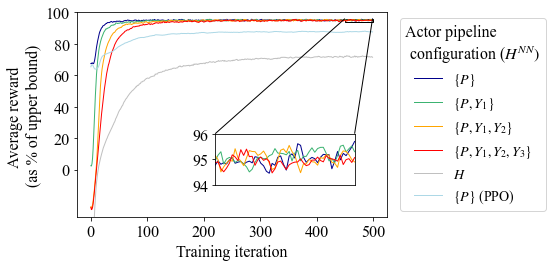

In [37]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import json
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Plot settings
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

# Data loading
default_path = "C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl_2/problem_configurations"
problem = "spirits_002"
configs = [
    "full_blending_p_nn_xy_lp_50w", "full_blending_py0_nn_xy12_lp_50w", 
    "full_blending_py01_nn_xy2_lp_50w", "full_blending_py_nn_x_lp_50w", 
    "full_blending_full_nn_none_lp_50w", "full_blending_p_nn_xy_lp_50w_ppo"
]
config_labels = [
    "$\\{P\\}$", "$\\{P,Y_1\\}$", "$\\{P,Y_1,Y_2\\}$", "$\\{P,Y_1,Y_2,Y_3\\}$", 
    "$H$", "$\\{P\\}$ (PPO)"
]
colors = ["darkblue", "mediumseagreen", "orange", "red", "silver", "lightblue"]

# Read CSV
data = {problem: {}}
with open(os.path.join(default_path, problem, "episode_reward_mean_50w.csv")) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for header, value in row.items():
            data[problem].setdefault(header, []).append(float(value))

# Main figure
fig, ax = plt.subplots(figsize=(8, 4))
xdata = np.array(data[problem]["Step"], dtype=int)

for idx, c in enumerate(configs):
    ydata = np.array(data[problem][c], dtype=float)
    ax.plot(xdata, ydata, color=colors[idx], linewidth=1, label=config_labels[idx])

ax.set_xlabel("Training iteration")
ax.set_ylabel("Average reward \n(as % of upper bound)")
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
ax.set_ylim(-0.3, 1.0)

# Inset (zoom) in bottom right
axins = inset_axes(ax, width="45%", height="25%", loc="lower right", borderpad=2)
for idx, c in enumerate(configs):
    ydata = np.array(data[problem][c], dtype=float)
    axins.plot(xdata, ydata, color=colors[idx], linewidth=1)

# Set zoom window
x1, x2 = xdata[-50], xdata[-1]
y1, y2 = 0.94, 0.96
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([0.94, 0.95, 0.96])
axins.set_yticklabels(["94", "95", "96"])

# Draw box and connector lines between zoom and inset
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="black", lw=1)

# Add legend outside plot
ax.legend(title="Actor pipeline \n configuration ($H^{NN})$", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=14)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(default_path, problem, "training_progress_pipelines.pdf"), bbox_inches='tight')
plt.show()


DONE PAIRS:  [['spirits_002', 'spirits_001'], ['spirits_012', 'spirits_011'], ['spirits_102', 'spirits_101'], ['spirits_112', 'spirits_111'], ['spirits_0002', 'spirits_0001'], ['spirits_1002', 'spirits_1001'], ['spirits_1102', 'spirits_1101'], ['spirits_0102', 'spirits_0101']]


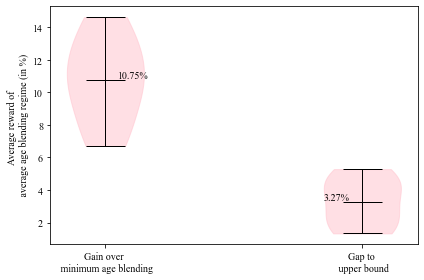

In [5]:
#BLENDING VALUE PLOT
#plot benefits of average age blending over minimum age blending
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
done_pairs = [p for p in matching_problems if p[0] in done_problems["average"] and p[1] in done_problems["minimum"]]
print("DONE PAIRS: ", done_pairs)
#use violin plot to show the distribution of the benefits of average age blending over minimum age blending
minimum_gain = [(data[p[0]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p[1]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_py_nn_x_lp"] - 1)*100 for p in done_pairs]
ub_gap = [-(data[p[0]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p[0]]["upper_bound"] - 1)*100 for p in done_pairs]
parts = plt.violinplot([minimum_gain, ub_gap] , widths=0.3, showmeans=True, showmedians=False)
#change color of violin plot
for pc in parts['bodies']:
    pc.set_facecolor('pink')
    pc.set_edgecolor('pink')
    pc.set_alpha(0.5)
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
plt.ylabel("Average reward of \n average age blending regime (in %)")
plt.xticks([1,2],["Gain over \n minimum age blending", "Gap to \n upper bound"])
#plt.xlabel("Blending regime")
#add text labels for the mean values
mean_values = [np.mean([(data[p[0]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p[1]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_py_nn_x_lp"] - 1)*100 for p in done_pairs])]
plt.text(1.05, mean_values[0], f"{mean_values[0]:.2f}%", ha='left', va='bottom')
mean_values = [np.mean([-(data[p[0]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p[0]]["upper_bound"] - 1)*100 for p in done_pairs])]
plt.text(1.95, mean_values[0], f"{mean_values[0]:.2f}%", ha='right', va='bottom')
#plt.xticks([])
plt.tight_layout()
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/average_vs_minimum.pdf")
plt.show()

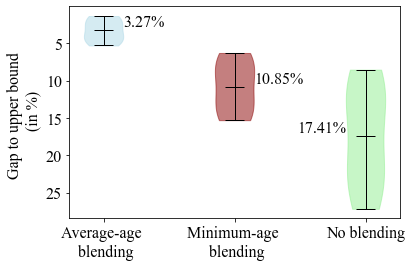

In [6]:
#BLENDING VALUE PLOT 2
#plot gap to upper bound for 0_blending, minimum and average age blending
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"]=16
#use violin plot to show the distribution of the benefits of average age blending over minimum age blending
ub_gap_0 = [(1 - data[p]["denorm_best_iteration"]["episode_reward_mean"]["0_blending_p_nn_xy_lp"]/data[p]["upper_bound"])*100 for p in done_problems["average"]]
ub_gap_avg = [(1 - data[p]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p]["upper_bound"])*100 for p in done_problems["average"]]
ub_gap_min = [(1 - data[p]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p]["upper_bound"])*100 for p in done_problems["minimum"]]
plot_data = [ ub_gap_avg, ub_gap_min, ub_gap_0]
parts = plt.violinplot(plot_data, widths=0.3, showmeans=True, showmedians=False, )
colors = ["lightblue",  "darkred", "lightgreen"]

#change color of individual violin plots according to colors vector
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor(color)
    pc.set_alpha(1)
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
plt.ylabel("Gap to upper bound \n (in %)")
plt.xticks([1,2,3],["Average-age \n blending", "Minimum-age \n blending", "No blending"])
#plt.xlabel("Blending regime")
#add text labels for the mean values
mean_values = [np.mean(plot_data[p][:]) for p in range(3)]
for i in range(3):
    if i > 1:
        plt.text(i+0.85, mean_values[i], f"{mean_values[i]:.2f}%", ha='right', va='bottom')
    else:
        plt.text(i+1.15, mean_values[i], f"{mean_values[i]:.2f}%", ha='left', va='bottom')
#plt.xticks([])
#flip y-axis
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/gap_to_upper_bound.pdf")
plt.show()


PermissionError: [Errno 13] Permission denied: 'C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/main_effects.pdf'

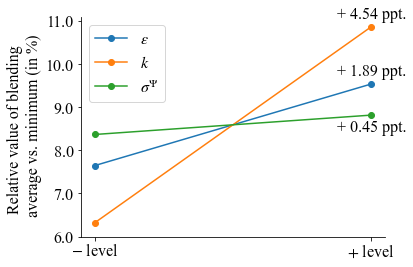

In [103]:
#blending_values = {p: (data[p]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"] - data[p]["denorm_best_iteration"]["episode_reward_mean"]["0_blending_p_nn_xy_lp"])/data[p]["denorm_best_iteration"]["episode_reward_mean"]["0_blending_p_nn_xy_lp"] for p in done_problems["average"]}
#
blending_values = {p: (data[p]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"] - data[minimum_equivalents[p]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"])/data[minimum_equivalents[p]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"] for p in done_problems["average"]}
#blending_values as percentage of the upper bound
#blending_values = {p: data[p]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p]["upper_bound"] - data[minimum_equivalents[p]]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"]/data[p]["upper_bound"] for p in done_problems["average"]}

#get main effects of factors on value of blending
factors = {"evaporation":  {"-": ["012", "112", "0102", "1102"], "+": ["002", "102", "0002", "1002"]}, "capacity": {"-": ["102", "112", "1002", "1102"], "+": ["002", "012", "0002", "0102"]}, "price": {"-": ["002", "012", "102", "112"], "+": ["0002", "0102", "1002", "1102"]}}
factor_labels = {"evaporation": "$\epsilon$", "capacity": "$k$", "price": "$\sigma^{\Psi}$"}

#change math font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})

#calculate the main effects of the factors on the value of blending
main_effects = {}
for factor in ["evaporation", "capacity", "price"]:
    #calculate the main effect of the factor
    main_effects[factor] = {"$-$": [blending_values[f"spirits_{f}"] for f in factors[factor]["-"]], "$+$": [blending_values[f"spirits_{f}"] for f in factors[factor]["+"]]}
    #calculate the average main effect
    
    #calculate the difference between the main effects
    main_effects[factor]["difference"] = np.array(main_effects[factor]["$+$"]) - np.array(main_effects[factor]["$-$"])

#plot the main effects of the factors as a line from minus to plus (on the x-axis, there should be "minus" and "plus" for each factor)
# the legend labels should be the factor labels
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
xdata = np.arange(2)
for factor in ["evaporation", "capacity", "price"]:
    ydata = [np.mean(main_effects[factor]["$-$"]), np.mean(main_effects[factor]["$+$"])]
    ax.plot(xdata, ydata, label=factor_labels[factor], marker='o')
plt.xticks(xdata, ["$-$ level", "$+$ level"])
plt.ylabel("Relative value of blending \n average vs. minimum (in %)")
plt.yticks([0.06, 0.07, 0.08, 0.09, 0.10, 0.11], ["6.0", "7.0", "8.0", "9.0", "10.0", "11.0"])
#add text label for difference
plt.text(xdata[1], np.mean(main_effects['evaporation']["$+$"])+0.001, f"+ {np.mean(main_effects['evaporation']['difference']*100):.2f} ppt.", ha='center', va='bottom')
plt.text(xdata[1], np.mean(main_effects['price']["$+$"])-0.001, f"+ {np.mean(main_effects['price']['difference']*100):.2f} ppt.", ha='center', va='top')
plt.text(xdata[1], np.mean(main_effects['capacity']["$+$"])+.001, f"+ {np.mean(main_effects['capacity']['difference']*100):.2f} ppt.", ha='center', va='bottom')

#remove plot frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



#take the legend labels in the legend from the factor_labels list
plt.legend()

plt.tight_layout()
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/main_effects.pdf")
plt.show()


#effect of factors on the absolute average reward
#calculate the main effects of the factors on the absolute average reward
main_effects = {}
for factor in ["evaporation", "capacity", "price"]:
    #calculate the main effect of the factor
    main_effects[factor] = {"$-$": [data[f"spirits_{f}"]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"] for f in factors[factor]["-"]], "$+$": [data[f"spirits_{f}"]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"] for f in factors[factor]["+"]]}
    #calculate the average main effect
    
    #calculate the difference between the main effects
    main_effects[factor]["difference"] = np.array(main_effects[factor]["$+$"]) - np.array(main_effects[factor]["$-$"])

#plot the main effects of the factors as a line from minus to plus (on the x-axis, there should be "minus" and "plus" for each factor)
# the legend labels should be the factor labels
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
xdata = np.arange(2)
for factor in ["evaporation", "capacity", "price"]:
    ydata = [np.mean(main_effects[factor]["$-$"]), np.mean(main_effects[factor]["$+$"])]
    ax.plot(xdata, ydata, label=factor_labels[factor], marker='o')
plt.xticks(xdata, ["$-$ level", "$+$ level"])
#add text label for difference
plt.text(xdata[1], np.mean(main_effects['evaporation']["$+$"])+40, f"{'+' if np.mean(main_effects['evaporation']['difference']) > 0 else ''} {np.mean(main_effects['evaporation']['difference']):.2f}", ha='right', va='bottom')
plt.text(xdata[1], np.mean(main_effects['price']["$+$"])-40, f"{'+' if np.mean(main_effects['price']['difference']) > 0 else ''} {np.mean(main_effects['price']['difference']):.2f}", ha='right', va='top')
plt.text(xdata[1], np.mean(main_effects['capacity']["$+$"]), f"{'+' if np.mean(main_effects['capacity']['difference']) > 0 else ''} {np.mean(main_effects['capacity']['difference']):.2f}", ha='right', va='bottom')

plt.ylabel("Average reward")
#place the legend outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(0.0,0.8))

plt.tight_layout()
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/main_effects_absolute_average.pdf")
plt.show()

#effect of factors on the absolute average reward
#calculate the main effects of the factors on the absolute average reward
main_effects = {}
for factor in ["evaporation", "capacity", "price"]:
    #calculate the main effect of the factor
    main_effects[factor] = {"$-$": [data[f"spirits_{f}".replace("2","1")]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"] for f in factors[factor]["-"]], "$+$": [data[f"spirits_{f}".replace("2","1")]["denorm_best_iteration"]["episode_reward_mean"]["full_blending_p_nn_xy_lp"] for f in factors[factor]["+"]]}
    #calculate the average main effect
    
    #calculate the difference between the main effects
    main_effects[factor]["difference"] = np.array(main_effects[factor]["$+$"]) - np.array(main_effects[factor]["$-$"])

#plot the main effects of the factors as a line from minus to plus (on the x-axis, there should be "minus" and "plus" for each factor)
# the legend labels should be the factor labels
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
xdata = np.arange(2)
for factor in ["evaporation", "capacity", "price"]:
    ydata = [np.mean(main_effects[factor]["$-$"]), np.mean(main_effects[factor]["$+$"])]
    ax.plot(xdata, ydata, label=factor_labels[factor], marker='o')
plt.xticks(xdata, ["$-$ level", "$+$ level"])
#add text label for difference
plt.text(xdata[1], np.mean(main_effects['evaporation']["$+$"])+40, f"{'+' if np.mean(main_effects['evaporation']['difference']) > 0 else ''} {np.mean(main_effects['evaporation']['difference']):.2f}", ha='right', va='bottom')
plt.text(xdata[1], np.mean(main_effects['price']["$+$"])-40, f"{'+' if np.mean(main_effects['price']['difference']) > 0 else ''} {np.mean(main_effects['price']['difference']):.2f}", ha='right', va='top')
plt.text(xdata[1], np.mean(main_effects['capacity']["$+$"]), f"{'+' if np.mean(main_effects['capacity']['difference']) > 0 else ''} {np.mean(main_effects['capacity']['difference']):.2f}", ha='right', va='bottom')

plt.ylabel("Average reward")
#place the legend outside of the plot area
plt.legend(loc='upper left', bbox_to_anchor=(0.0,0.8))

plt.tight_layout()
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/main_effects_absolute_minimum.pdf")
plt.show()




In [15]:
from sklearn import *

done_pairs = [p for p in matching_problems if p[0] in done_problems["average"] and p[1] in done_problems["minimum"]]
config = "full_blending_p_nn_xy_lp"

#create decision trees for all problems using the regression data (don't plot the tree, but evaluate the performance of the tree on the training data and the test data)
feature_importances = {}
for p1,p2 in done_pairs:
    #get regression data from json file
    with open(default_path+"/"+p1+"/training_results/"+config+"/regression_data.json", 'r') as f:
        regression_data = json.load(f)
    X = np.array(regression_data["features"])
    #only get the first response value
    y = np.array(regression_data["responses"])[:,0]
    
    #split data into training and test data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
    #create decision tree regressor
    clf = tree.DecisionTreeRegressor()
    clf.fit(X_train, y_train)
    #evaluate the performance of the tree on the training data
    y_train_pred = clf.predict(X_train)
    mse_train = metrics.mean_squared_error(y_train, y_train_pred)
    print("MSE TRAINING: ", mse_train)
    R2_train = metrics.r2_score(y_train, y_train_pred)
    print("R2 TRAINING: ", R2_train)
    #evaluate the performance of the tree on the test data
    y_test_pred = clf.predict(X_test)
    mse_test = metrics.mean_squared_error(y_test, y_test_pred)
    print("MSE TEST: ", mse_test)
    R2_test = metrics.r2_score(y_test, y_test_pred)
    print("R2 TEST: ", R2_test)
    
    #get the feature importances with the feature names
    feature_names = ["$\Psi$"] + ["$s_1$", "$s_2$","$s_3$","$s_4$","$s_5$","$s_6$","$s_7$","$s_8$","$s_9$","$s_{10}$"]
    feature_importances[p1] = clf.feature_importances_
    for i in range(len(feature_names)):
        print(f"{feature_names[i]}: {feature_importances[p1][i]}")
#create a plot of the feature names and a boxplot of the feature importances for all problems
xdata = feature_names
ydata = np.array([feature_importances[p] for p in done_pairs])
plt.boxplot(ydata)

plt.xticks(xdata, feature_names, rotation=45)
plt.ylabel("Feature importance")
plt.xlabel("Feature")
plt.tight_layout()
#plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/feature_importance.pdf")
plt.show()
     


MSE TRAINING:  0.0
R2 TRAINING:  1.0
MSE TEST:  9.973999243208754
R2 TEST:  0.9786389721715498
$\Psi$: 0.905359465516078
$s_1$: 0.03318993637886851
$s_2$: 0.025766607719231935
$s_3$: 0.01803346448836075
$s_4$: 0.0074859315181139505
$s_5$: 0.0050534331445114605
$s_6$: 0.002288271837245157
$s_7$: 0.0007877128017059873
$s_8$: 0.0007872476319903187
$s_9$: 0.000613164643493318
$s_{10}$: 0.000634764320400685
MSE TRAINING:  0.0
R2 TRAINING:  1.0
MSE TEST:  17.636540438963735
R2 TEST:  0.9625188865180333
$\Psi$: 0.8690555564827603
$s_1$: 0.038744417408797895
$s_2$: 0.031624050990998784
$s_3$: 0.022445048905472158
$s_4$: 0.01417389611709542
$s_5$: 0.012504399672197507
$s_6$: 0.005988215346905052
$s_7$: 0.0020298866220978284
$s_8$: 0.0012209561359815663
$s_9$: 0.001123481880561487
$s_{10}$: 0.0010900904371319382
MSE TRAINING:  0.0
R2 TRAINING:  1.0
MSE TEST:  1.5501389704117885
R2 TEST:  0.9902696602036941
$\Psi$: 0.9722256372389725
$s_1$: 0.008052574261511675
$s_2$: 0.005911493506457574
$s_3$: 

TypeError: unhashable type: 'list'

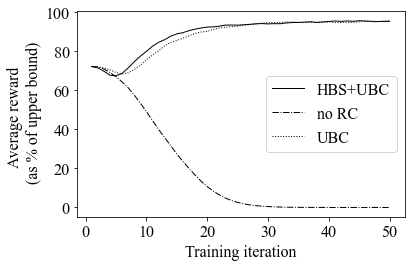

In [7]:
import csv
import matplotlib.pyplot as plt
import numpy as np


default_path = "C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations"

#array of problem configuration folders
problem = "spirits_012"
configs = ["full_blending_p_nn_xy_lp", "full_blending_p_nn_xy_lp_nonormalization", "full_blending_p_nn_xy_lp_nohistory"]
labels = ["HBS+UBC", "no RC", "UBC"]
linestyles = ['solid', '-.', ':']
kpis = ["percentage_ub"]

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})

#open csv-files and store data in dictionary
data = {}
with open(default_path+"/"+problem + "/summary_reward_shaping.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    data = {}
    for row in reader:
        for header, value in row.items():
            data.setdefault(header, []).append(value)

rewards = {}
for c in configs:
    rewards[c] = np.array(data[f"{c} - percentage_ub"], dtype=float)

xdata = np.arange(1, 51)
#plot data
for c in configs:
    plt.plot(xdata, rewards[c][:50], label=labels[configs.index(c)], color="black", linestyle=linestyles[configs.index(c)], linewidth=1.0)
    
#plt.plot(xdata, np.array([(0.9056923321578674+1)/2]*50), color='black', linewidth=1.0, linestyle='--', label="LP")
plt.xlabel("Training iteration")
plt.ylabel("Average reward \n (as % of upper bound)")
plt.legend()
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "20", "40", "60", "80", "100"])
#resize the plot so that y label is not cut off
plt.tight_layout()
#save plot
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/"+problem+"/average_reward_shaping.pdf")
plt.show()


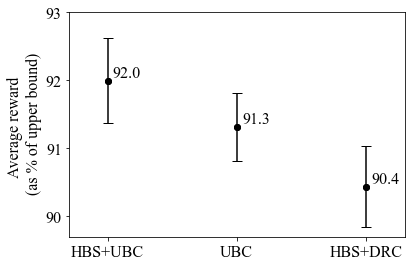

In [10]:
import json
pid = "spirits_012"

paths = {"HBS+UBC": "full_blending_p_nn_xy_lp_50w", "UBC": "full_blending_p_nn_xy_lp_nohistory", "HBS+DRC": "full_blending_p_nn_xy_lp_default_normalization"}

#load regression data and get average rewards
data = {}
rewards = {}
for s, p in paths.items():
    data[s] = json.load(open(f"C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/{pid}/training_results/{p}/regression_data.json", "r"))
    rewards[s] = data[s]["rewards"]

markers = ["o", "s", "D"]


import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()

average_rewards = {s: [np.mean(rewards[s][i:i+2500]) for i in range(0, len(rewards[s])-1, 2500)] for s in paths.keys()}
ydata = [average_rewards[s] for s in paths.keys()]

confidence_average_rewards = {s: 1.96 * np.std(average_rewards[s])/np.sqrt(20) for s in paths.keys()}
lerr = [confidence_average_rewards[s] for s in paths.keys()]
uerr = [confidence_average_rewards[s] for s in paths.keys()]
yerr = [lerr, uerr]
#plot mean for each config as marker and min and max as whiskers
ax.plot([0,1,2], [np.mean(average_rewards[s]) for s in paths.keys()], color='black', linestyle="", marker="o")
ax.errorbar([0,1,2], [np.mean(average_rewards[s]) for s in paths.keys()], yerr=yerr, fmt="o", color="black", capsize=5)
#add text labels for the mean values
for s in paths.keys():
    plt.text([0,1,2][list(paths.keys()).index(s)]+0.15, np.mean(average_rewards[s]), f"{np.mean(average_rewards[s])*100:.1f}", ha='center', va='bottom')

ax.set_xlim(-0.3, 2.3)

ax.set_xticks([0,1,2], ["HBS+UBC", "UBC", "HBS+DRC"])
ax.set_ylabel("Average reward \n (as % of upper bound)")
ax.set_yticks([0.9, 0.91, 0.92, 0.93], ["90", "91", "92", "93"])
plt.tight_layout()  

plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/"+pid+"/reward_comparison_shaping.pdf")
